# SVM, SVR

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import pickle

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, KFold, RepeatedKFold
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.svm import SVC, SVR # Support Vector Classifier, Support Vector Regressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler # z-score scaling

In [4]:
data1 = pd.read_csv('data/svm_sample_data.csv')

data1.head()

,X1,X2,group
0,-0.399787,-2.330325,1
1,0.378372,2.316998,2
2,-0.671843,-2.014193,1
3,0.717850,2.435676,2
4,-0.969550,-1.877690,1


<Axes: xlabel='X1', ylabel='X2'>

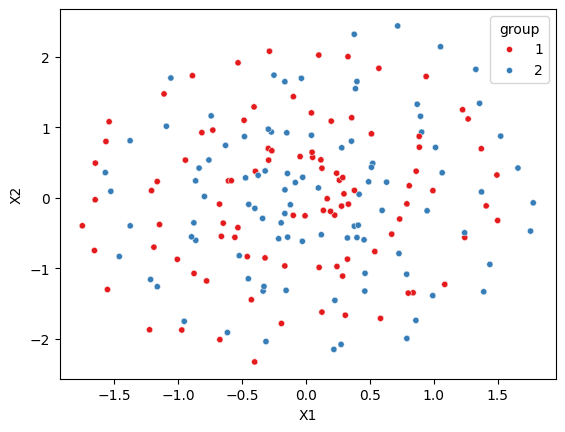

In [6]:
# see how it looks like 

sns.scatterplot(
    data = data1,
    x = 'X1',
    y = 'X2',
    palette = 'Set1',
    hue = 'group',
    s = 20 # point size
)

# these are artificial data with two groups that cannot be separated with Linear Line

# there is seemingly no sensible division here,
# but upon closer inspection you can see spiral shapes

In [10]:
# split the data into training and test sets
data1_train, data1_test = train_test_split(
    data1,
    test_size = 0.3,
    # stratify ensures the train and test sets keep the same class/group proportions
    # as the original data.
    stratify = data1['group'],
    random_state = 123
)

In [14]:
# check the distribution of the groups in the training set
data1_train['group'].value_counts()

group
1    134
2    134
Name: count, dtype: int64

## SVM with a linear kernel

In [17]:
# try to linearly separate the data using SVM with linear kernel

# extracting features and target variable
X_train = data1_train[['X1', 'X2']]
y_train = data1_train['group']

# initialize the SVM classifier with linear kernel
svm_linear = SVC(kernel = 'linear') # default C = 1.0

svm_linear.fit(X_train, y_train)

SVC(kernel='linear')

In [21]:
X_test = data1_test[['X1', 'X2']]
y_test = data1_test['group']

data1_test['fore_svm_linear'] = svm_linear.predict(X_test)

data1_test.head(10)

,X1,X2,group,fore_svm_linear
209,1.756231,-0.474438,2,2
140,-0.645603,-0.361586,1,1
364,0.379824,0.102496,1,2
212,-1.537416,1.076873,1,1
128,-0.164070,-0.968967,1,2
275,1.241251,-0.497877,2,2
236,1.493490,0.320792,1,2
34,0.570947,1.834724,1,1
348,-0.265882,0.665358,1,1
355,-0.212419,-0.582589,2,2


In [23]:
# frequency of the predicted classes
data1_test['fore_svm_linear'].value_counts()

fore_svm_linear
2    58
1    58
Name: count, dtype: int64

In [27]:
# frequency of the original classes
data1_test['group'].value_counts()

group
2    58
1    58
Name: count, dtype: int64

In [29]:
# confusion matrix

confusion_matrix(
    data1_test['group'], # original data
    data1_test['fore_svm_linear'] # predicted data
)

array([[30, 28],
       [28, 30]], dtype=int64)

In [35]:
# classification report

print(classification_report(
    data1_test['group'],
    data1_test['fore_svm_linear'],
    zero_division = 0
))

# very bad - random guess would be equally good

              precision    recall  f1-score   support

           1       0.52      0.52      0.52        58
           2       0.52      0.52      0.52        58

    accuracy                           0.52       116
   macro avg       0.52      0.52      0.52       116
weighted avg       0.52      0.52      0.52       116



## SVM with a polynomial kernel

In [38]:
# check polynomial kernel which has more hyperparameters
# - C -> same as above (cost of wrong classification)
# - degree -> degree of the polynomial (default = 3)
# - gamma/scale -> scaling parameter
#               k(x, y) = (gamma*x'y + coef) ^ degree

# initializing the SVM classifier with polynomial kernel
svm_poly = SVC(
    kernel = 'poly',
    max_iter = 20000 # to get the result faster - instead of the default -1
                     # otherwise it may take a long time to converge
)

# grid of hyperparameters for polynomial kernel
svm_poly_grid = {
    'C' : [0.001, 1, 5],
    'degree' : [2, 3, 4, 5],
    'gamma' : [1.0], # lets use just one value of 1.0
    'coef0' : [1.0]  # lets use just one value of 1.0
}

# here simple 5-Fold Cross-Validation
cv5 = KFold(
    n_splits = 5,
    shuffle = True,
    random_state = 123
)

# Initialization of GridSearchCV
svm_poly_tuned = GridSearchCV(
    estimator = svm_poly, # model defined above
    param_grid = svm_poly_grid, # grid of hyperparameters
    scoring = 'roc_auc', # evaluation metric
    cv = cv5, # KFold Cross-Validation
    n_jobs = - 1
)

svm_poly_tuned.fit(X_train, y_train)

print('Best hyperparameters:', svm_poly_tuned.best_params_)
print('Best AUC:', svm_poly_tuned.best_score_)

Best hyperparameters: {'C': 0.001, 'coef0': 1.0, 'degree': 3, 'gamma': 1.0}
Best AUC: 0.549058464594863


In [40]:
svm_best_model = svm_poly_tuned.best_estimator_
svm_best_model

SVC(C=0.001, coef0=1.0, gamma=1.0, kernel='poly', max_iter=20000)

In [44]:
# check the model performance on the test data

data1_test['fore_svm_poly_tuned'] = svm_best_model.predict(X_test)

# classification report
print(classification_report(
    y_true = data1_test['group'],
    y_pred = data1_test['fore_svm_poly_tuned'],
    zero_division = 0
))

# looks equally bad as the linear kernel

              precision    recall  f1-score   support

           1       0.51      0.86      0.64        58
           2       0.53      0.16      0.24        58

    accuracy                           0.51       116
   macro avg       0.52      0.51      0.44       116
weighted avg       0.52      0.51      0.44       116



## SVM with a Gaussian radial basis kernel function (RBF):

In [52]:
# compare the radial basis function (RBF) kernel
# which has two hyperparameters:
# - C -> as above (cost of wrong classification)
# - gamma -> scaling parameter
#      k(x, y) = exp(-gamma||x-y||^2)

# define the SVM classifier with RBF kernel
svm_rbf = SVC(
    kernel = 'rbf', # radial basis function (RBF)
    max_iter = 20000 # limit of iterations
)

# grid of hyperparameters for RBF kernel
svm_rbf_grid = {
    'C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
    'gamma' : [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]
}

# initialization of GridSearchCV with cv5
svm_rbf_tuned = GridSearchCV(
    estimator = svm_rbf, # model 
    param_grid = svm_rbf_grid, # grid of hyperparameters
    scoring = 'roc_auc', # evaluation metric
    cv = cv5,
    n_jobs = -1
)

svm_rbf_tuned.fit(X_train, y_train)

print('Best hyperparameters:', svm_rbf_tuned.best_params_)
print('Best AUC:', svm_rbf_tuned.best_score_)

# AUC score improved from 54 to 92 so model is good
# this is based on training data ... now do it on test data

Best hyperparameters: {'C': 5, 'gamma': 100}
Best AUC: 0.9269799205335602


In [54]:
svm_rbf_best_model = svm_rbf_tuned.best_estimator_
svm_rbf_best_model

SVC(C=5, gamma=100, max_iter=20000)

In [56]:
# check the model performance on the test set
data1_test['fore_svm_rbf_tuned'] = svm_rbf_tuned.predict(X_test)

print(classification_report(
    y_true = data1_test['group'],
    y_pred = data1_test['fore_svm_rbf_tuned'],
    zero_division = 0
))

# looks BEST so far. Well predicts both classes

              precision    recall  f1-score   support

           1       0.89      0.83      0.86        58
           2       0.84      0.90      0.87        58

    accuracy                           0.86       116
   macro avg       0.86      0.86      0.86       116
weighted avg       0.86      0.86      0.86       116



In [62]:
confusion_matrix(
    data1_test['group'],
    data1_test['fore_svm_rbf_tuned']
)

# confusion matrix results are also quite good

array([[48, 10],
       [ 6, 52]], dtype=int64)

## SVM in Classification on `churn` dataset

In [65]:
churn_train_encoded = pd.read_pickle('data/churn_train_encoded.pkl')
churn_test_encoded = pd.read_pickle('data/churn_test_encoded.pkl')

churn_train_encoded.head()

,customer_id,customer_age,customer_number_of_dependents,customer_education,customer_salary_range,customer_relationship_length,customer_available_credit_limit,total_products,period_inactive,contacts_in_last_year,...,average_utilization,customer_gender_M,customer_gender_Unknown,customer_civil_status_Married,customer_civil_status_Single,customer_civil_status_Unknown,credit_card_classification_Gold,credit_card_classification_Platinum,credit_card_classification_Silver,account_status_1
4694,799562,50.0,2.0,2.0,1.0,37.0,13384.0,1.0,3.0,2.0,...,0.000,0,0,1,0,0,0,0,1,0
1263,282706,52.0,1.0,2.0,5.0,36.0,31945.0,4.0,3.0,5.0,...,0.050,1,0,0,0,0,0,0,0,0
4427,837683,46.0,3.0,1.0,3.0,36.0,5489.0,5.0,1.0,2.0,...,0.217,1,0,0,1,0,0,0,0,0
8746,384742,53.0,5.0,0.0,4.0,48.0,9517.0,6.0,1.0,0.0,...,0.196,1,0,1,0,0,0,0,0,0
4386,618362,59.0,0.0,4.0,2.0,53.0,4241.0,3.0,2.0,3.0,...,0.000,1,0,1,0,0,0,0,0,0


In [67]:
churn_train_X = churn_train_encoded.drop(['account_status_1', 'customer_id'], axis = 1)
churn_train_y = churn_train_encoded['account_status_1']

In [79]:
# IMPORTANT !

# SVM model estimation can be very time-consuming
# for large datasets (also for a large number of variables)

# lets compare SVC-based classification with polynomial (poly) 
# and Gaissian (RBF) kernels
# additionally we will apply variables standardization to z-scores


# initialization of SVM with polynomial kernel
churn_svm_poly = SVC(
    kernel = 'poly',
    max_iter = 20000,
    tol = 0.01
)

# define pipeline: scaling + churn_svm_poly := z-score + model
churn_svm_poly_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()), # scaling to z-score
        ('model', churn_svm_poly)     # model
    ]
)

# grid of hyperparameters with appropriate names
svm_poly_grid = {
    'model__C' : [0.001, 0.01, 1, 5],
    'model__degree' : [2, 3, 4],
    'model__gamma' : [1.0],
    'model__coef0' : [1.0]
}

# simple Cross-Validation with 5 Folds
cv5 = KFold(
    n_splits = 5, 
    shuffle = True,
    random_state = 123
)

# Initialization of GridSearchCV
churn_svm_poly_tuned = GridSearchCV(
    estimator = churn_svm_poly_pipeline,
    param_grid = svm_poly_grid, # grid of hyperparameters
    scoring = 'roc_auc', # evaluation metric
    cv = cv5,
    n_jobs = -1
)

churn_svm_poly_tuned.fit(churn_train_X, churn_train_y)

print('Best parameters:', churn_svm_poly_tuned.best_params_)
print('Best AUC:', churn_svm_poly_tuned.best_score_)

# AUC result: 0.91
# as a reminder - for logistic regression it was 0.88, for KNN auc score was 0.85
# reminder: this result is based on training sample

Best parameters: {'model__C': 0.01, 'model__coef0': 1.0, 'model__degree': 2, 'model__gamma': 1.0}
Best AUC: 0.9125702318076561


In [85]:
# SVM model with RBF kernel

# Initialization of SVM with RBF kernel
churn_svm_rbf = SVC(
    kernel = 'rbf',
    max_iter = 20000,
    tol = 0.01
)

# define a pipeline: scaling + model (churn_svm_rbf)
churn_svm_rbf_pipeline = Pipeline(
    [
        ('scaler', StandardScaler()),  # scaling -> z-score
        ('model', churn_svm_rbf)       # model
    ]
)

# grid of hyperparameters with appropriate names
svm_rbf_grid = {
    'model__C' : [0.01, 0.05, 0.1, 0.5, 1, 5, 10, 25, 50, 100],
    'model__gamma': [0.001, 0.01, 0.05, 0.1, 0.2, 0.5, 1, 10, 100]
}

# lets use RandomizedSearch here to check just selected combinations
churn_svm_rbf_tuned = RandomizedSearchCV(
    estimator = churn_svm_rbf_pipeline, # model
    param_distributions = svm_rbf_grid, # param grid
    n_iter = 20, # we will check 20 combinations
    scoring = 'roc_auc', # evaluation metric
    cv = cv5, # KFold
    n_jobs = -1
)

churn_svm_rbf_tuned.fit(churn_train_X, churn_train_y)

print('Best parameters:', churn_svm_rbf_tuned.best_params_)
print('Best AUC:', churn_svm_rbf_tuned.best_score_)

# This AUC result is even better than the one with polynomial kernel - 0.92
# these results are from train sample not test

Best parameters: {'model__gamma': 0.001, 'model__C': 100}
Best AUC: 0.910147078455644


In [83]:
# could not .predict() the model on test sample because I dont have test data

In [88]:
# save the models to pickle files

with open('data/churn_model_svm_poly.pkl', 'wb') as f:
    pickle.dump(churn_svm_poly_tuned, f)

with open('data/churn_model_svm_rbf.pkl', 'wb') as f:
    pickle.dump(churn_svm_rbf_tuned, f)

## SVR to regression problem

In [90]:
# import the 'houses' dataset
# split into train and test data prepared before

with open('data/houses_prepared_encoded.pkl', 'rb') as f:
    houses_train_encoded = pickle.load(f)
    houses_test_encoded = pickle.load(f)

houses_test_encoded.head()

,Order,PID,Lot_Frontage,Lot_Area,Lot_Shape,Land_Slope,Overall_Qual,Overall_Cond,Year_Built,Year_Remod_Add,...,Sale_Type_New,Sale_Type_Other,Sale_Type_WD,Sale_Condition_Family,Sale_Condition_Normal,Sale_Condition_Other,Sale_Condition_Partial,Land_Contour_HLS,Land_Contour_Low,Land_Contour_Lvl
0,1,526301100,141,31770,1.0,0.0,4.0,5.0,1960,1960,...,0,0,1,0,1,0,0,0,0,1
1,2,526350040,80,11622,0.0,0.0,5.0,4.0,1961,1961,...,0,0,1,0,1,0,0,0,0,1
2,3,526351010,81,14267,1.0,0.0,4.0,4.0,1958,1958,...,0,0,1,0,1,0,0,0,0,1
3,4,526353030,93,11160,0.0,0.0,3.0,5.0,1968,1968,...,0,0,1,0,1,0,0,0,0,1
4,5,527105010,74,13830,1.0,0.0,5.0,5.0,1997,1998,...,0,0,1,0,1,0,0,0,0,1


In [92]:
# modeling is analogous to classification
# (the same kernel function, ex: "linear", "poly", "rbf"
# and the same values of their hyperparameters)

# only instead of SVC() we will use SVR()

houses_train_X = houses_train_encoded.drop(['Sale_Price', 'Order', 'PID'], axis = 1)
houses_train_y = houses_train_encoded['Sale_Price']

houses_test_X = houses_test_encoded.drop(['Sale_Price', 'Order', 'PID'], axis = 1)

# we will estimate ONE model (without cross-validation)
# and without standardization of variables

# lets use the hyperparameter values that turned out to be the best
# for churn classification: {'model__gamma': 0.01, 'model__C': 50}

# of course there is NO REASON to think that for another dataset
# and a completely different problem (regression) they will also be optimal

houses_svr_rbs = SVR(
    kernel = 'rbf',
    max_iter = 20000,
    tol = 0.01,
    gamma = 0.01,
    C = 50
)

houses_svr_rbs.fit(houses_train_X, houses_train_y)

SVR(C=50, gamma=0.01, max_iter=20000, tol=0.01)

<Axes: ylabel='Count'>

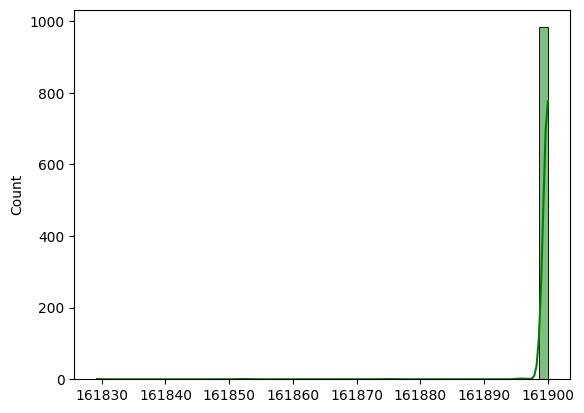

In [96]:
# model has been estimated

# Prediction
y_pred = houses_svr_rbs.predict(houses_test_X)

# lets see histogram of predicted prices
sns.histplot(y_pred, bins = 50, kde = True, color = 'green')

# does not look well...